# "R.U.Stoked: Go Deep!"
> "Here I have tried to tackle a text classification problem using RNN (deep learning). I wrote abou first phase of this personal project which was implemented in sklearn using the ensemble ReandomForest classifier."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [text classifier, deep learning, pytorch, fastai, sentiment analysis, RNNs]
- image: images/rustoked_deep/sm_preview.png
- hide: false
- search_exclude: true

![](2021-10-28-rustoked-deep/cover.jpg)

# Introduction
In order to explore further possibilities to improve my personal project [R.U.Stoked](https://mohsen-saki.github.io/bordar/nlp/sentiment%20analysis/machine%20lerarning/sklearn/data%20processing/pandas/bokeh/random%20forest/feature%20engineering/2021/03/17/rustoked.html), I have developed here a neural net (deep learning) application to see how it will pan out given my problem case. 
> **Just a quick recap:** in this problem I have been trying to capture a third sentiment class `disengaged` among `stoked` and `dissatisfied` user reviews. The main idea is identifying a group of users/customers that belong to a gray area and are probably an interesting category for a business to focus on (in _churn_ or _loyalty_ business cases).


I have used `Pytorch` and on top of that `fastai` library to do so. Feel free to give it a go by opening this notebook in google colab.

In [15]:
#collapse
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.text.all import *

import warnings
warnings.filterwarnings('ignore')


# utility functions used to clean and prepoare the dataset
def get_clean_df(df, drop_columns=False):
    """
    cleanup and format initial DataFrame
    :param df: raw DataFrame
    :return: Processed DataFrame 
    """

    # concat `title`, `pros`, and `cons` as body of each review
    df['reviews'] = df['title'].str.cat(df['pros'].str.cat(df['cons'], sep=" ", na_rep=""), sep=" ", na_rep="")
    df.drop(['title', 'pros', 'cons'], axis=1, inplace=True)

    # handling missing data
    df['job_title'] = df['job_title'].fillna('unknown')
    df['location'] = df['location'].fillna('Australia')

    # casting right type to column
    df['career_opportunity_rating'] = df['career_opportunity_rating'].astype(int)
    df['work_life_balance_rating'] = df['work_life_balance_rating'].astype(int)
    df['work_env_rating'] = df['work_env_rating'].astype(int)
    df['management_rating'] = df['management_rating'].astype(int)
    df['benefits_rating'] = df['benefits_rating'].astype(int)
    df['diversity_rating'] = df['diversity_rating'].astype(int)
    df['overall_rating'] = df['overall_rating'].astype(int)

    # cleaning 'recommendation' & 'salary' columns
    df['recommendation'] = df['recommendation'].str.split().str[-1]
    df['salary'] = df['salary'].str.split().str[-1]

    # new column for overal rating calculated based on employee ratings
    df["calculated_rating"] = df[["career_opportunity_rating", "work_life_balance_rating",
                              "work_env_rating", "management_rating", "benefits_rating",
                              "diversity_rating"]].mean(axis=1).round()

    # removing those reviews with two points difference between overall and calculated rating
    df = df[~(abs(df['overall_rating'] - df['calculated_rating']) > 1)]

    # mapping ratings to three different category labels
    df["labels"] = [get_labels(rating) for rating in df["overall_rating"]]

    if drop_columns:
        df.drop(drop_columns, axis=1, inplace=True)

    return df



def get_labels(rating):
    """
    map each reating to a label category used by clean_raw_dataframe() function
    :rating: overal rating given by employee
    "return: data labels
    """
    if rating in [1, 2]: return "dissatisfied"
    elif rating == 3: return "disengaged"
    else: return "stoked"


# Dataset
I used [the same dataset](https://github.com/mohsen-saki/RUStoked/tree/master/data) which is fairly a small set of data points (about 13k) and not quite evenly distributed regarding target labels.

In [2]:
#collapse
PATH_DATA = "https://github.com/mohsen-saki/RUStoked/raw/master/data/raw_data.csv"

df = pd.read_csv(PATH_DATA)

df = get_clean_df(df)
df = df[['reviews', 'labels']]
df.head(3)

,reviews,labels
0,"‘Okay, given your prepared to work long days.’ Plenty of hours for casual staff if willing to work a variety of shifts. If you work hard there are programs in place to progress your career. Salary for DM can be okay depending on how well you can negotiate. Poor work/life balance for DM's who want to achieve KPI's as there is not the budget to achieve with team, you are required to put in quite a few hours extra sometimes upwards of 60+. Some team can be reluctant to do their job properly and do not react well to any change, namely older full time team who have worked for the business for a...",disengaged
1,"‘Great job to gain work experience and interpersonal skills, plenty of opportunity for moving into manager roles. ’ Great job to further develop interpersonal skills. Opportunity to work in different areas and generally working with a great team. Working on weekends and public holidays often.",stoked
2,"‘Great for someone starting out. Can get stifled in Middle Management.’ Boss is not intense. Good Work Vs Life balance. \r\nInteresting workplace. Great customers. Moving the business through change. Setting the vision. \r\nCareer progression, navigating office politics. \r\nDiversity should not just be about gender equality. But, also include age, race, sexual preference.",stoked


In [3]:
#collapse
print("Total number of each label in the dataset: ")
df.labels.value_counts()

Total number of each label in the dataset: 


stoked          6076
dissatisfied    3666
disengaged      2359
Name: labels, dtype: int64

# Model Development
I applied the [**ULMFiT**](https://arxiv.org/abs/1801.06146) approach which is basically fine tuning the language model to the dataset before training a classifier using transfer learning. fastai uses `wt103-fwd` as default pre-trained language model trained on Wikipedia articles.

Processed text look like this:

In [4]:
#collapse
dls_lm = DataBlock(
    blocks=TextBlock.from_df('reviews', is_lm=True, seq_len=72),
    get_items=ColReader('reviews'),
    splitter=RandomSplitter(0.1),
).dataloaders(df, bs=128)

dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos ‘ open xxunk is not tolerated . ’ xxmaj flexible working arrangements , work life balance . xxmaj management do not listen , stick to their ideas and their wellbeing xxbos ‘ love working in xxup cba . ’ xxmaj great culture and great people . xxmaj flexible working hours allowed . xxmaj overall good opportunities to move around in the business . xxmaj bureaucracy in some departments . xxbos ‘","‘ open xxunk is not tolerated . ’ xxmaj flexible working arrangements , work life balance . xxmaj management do not listen , stick to their ideas and their wellbeing xxbos ‘ love working in xxup cba . ’ xxmaj great culture and great people . xxmaj flexible working hours allowed . xxmaj overall good opportunities to move around in the business . xxmaj bureaucracy in some departments . xxbos ‘ very"
1,and travel xxmaj none i enjoyed working there xxbos ‘ over worked for no appreciation ’ xxmaj busy because of lack of staff makes it an xxunk challenge working there xxmaj no training upper xxmaj management are horrible and always looking to blame someone for any minor issue they could just fix and move on xxbos ‘ so so ’ xxmaj friends xxmaj managers xxbos ‘ pleasant ’ xxmaj working with a,travel xxmaj none i enjoyed working there xxbos ‘ over worked for no appreciation ’ xxmaj busy because of lack of staff makes it an xxunk challenge working there xxmaj no training upper xxmaj management are horrible and always looking to blame someone for any minor issue they could just fix and move on xxbos ‘ so so ’ xxmaj friends xxmaj managers xxbos ‘ pleasant ’ xxmaj working with a great


## Fine-Tuning the Language Model

First, I will fine tune the task specific layer (vocab embeddings) of the language model for one epoch.

In [16]:
#collapse
learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity]
).to_fp16()

learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.493875,3.905818,0.269686,49.690720,01:20


Then, unfreeze the model and fine-tune for a couple of more epochs.

In [6]:
#collapse
learn.unfreeze()
learn.fit_one_cycle(7, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.033870,3.735572,0.287698,41.911976,01:37
1,3.863568,3.597275,0.303558,36.498657,01:37
2,3.730047,3.536184,0.310000,34.335640,01:38
3,3.607229,3.496449,0.315343,32.998066,01:38
4,3.494903,3.468141,0.319108,32.077065,01:36
5,3.430470,3.460073,0.320368,31.819315,01:41
6,3.375872,3.460871,0.321032,31.844700,01:37


In the end, I saved the `encoder` (fine tuned model without the task specific final layer) for the next step which is training a text classifier.

In [7]:
#collapse
learn.save_encoder('finetuned')

## Fine-Tuning Text Classifier

Next is time for training the classifier. Need to load saved `encoder` first.
Then to fine tune the model while unfreezing little by little.

The dataset for classfier look like this:


In [8]:
#collapse
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('reviews', vocab=dls_lm.vocab, seq_len=72), CategoryBlock),
    get_x = ColReader('text'),
    get_y = ColReader('labels'),
    splitter=RandomSplitter(0.2)
).dataloaders(df, bs=128)

dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos ‘ i tried to do the best job i could in difficult circumstances , but was xxunk for it . ’ i enjoyed the physically demanding and xxunk stimulating nature of the job in my work as a xxmaj field xxmaj xxunk over 35 years in various customer - facing roles . i found that working in company with groups of individuals who had the commitment to provide the best that they could to a very high standard to be both xxunk and inspirational . xxmaj the people i worked with were open and willing to giving advice and assistance without xxunk or xxunk . xxmaj while it was impossible to avoid personality conflicts all of the time , mutual respect for the individual was evident due to the knowledge , skills , capabilities , and experience that each of my colleagues xxunk . i enjoyed the challenges related",dissatisfied
1,"xxbos ‘ i would n't recommend the xxmaj graduate xxmaj program here ’ xxmaj met some really great people here and my direct mangers were always lovely . xxmaj though incredibly time - poor , they were always friendly and did their best to support you when possible . xxmaj you do learn a lot about the xxmaj retail / xxup xxunk industry and related fields ( product xxmaj development , xxmaj marketing etc ) so if you 're willing to put in long hours and ask lots of questions , you will gain a lot of knowledge and valuable industry experience . xxmaj the pay was also excellent , though you have to weigh up if it 's really worth it based on the lack of work - life balance . xxmaj if you are a very competitive , profit - driven person and your career is your priority",dissatisfied
2,"xxbos ‘ great team , learnt a xxup lot , fast paced , can be stressful and challenging . ’ xxmaj the xxunk are awesome with amazing xxunk , great learning sessions and culture building activities . \n\n xxmaj it 's a fast paced environment so you 'll never get bored . \n\n xxmaj my team was very supportive and were flexible with my work arrangements well beyond any other company xxmaj i 've ever worked for . * this may not be the same across every team * \n\n xxup seek is inclusive and genuinely wants to match the right candidate to the right job . xxmaj xxunk employers on the issues surrounding "" xxunk bias "" and putting tools in place to help minimise it was particularly rewarding to be a part of . xxmaj you see many xxup xxunk , people with xxunk and different age xxunk",stoked


First, train for one epoch:

In [9]:
#collapse
learn = text_classifier_learner(dls_clas, AWD_LSTM, metrics=accuracy).to_fp16()

learn.load_encoder('finetuned')

learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.659904,0.644060,0.723140,00:28


Train one more epoch by unfreezing two last layers:

In [10]:
#collapse
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.613120,0.599738,0.735537,00:31


Train one more epoch by unfreezing three last layers:

In [11]:
#collapse
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.549451,0.581448,0.743388,00:50


And last, two more epochs having all layers unfreezed:

In [12]:
#collapse
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.487775,0.610825,0.743802,01:04
1,0.457831,0.620456,0.739256,01:04


# Model Performance & Outcome

Comparing model performance with the [Machine Learning version (RandomForest)](https://mohsen-saki.github.io/bordar/nlp/sentiment%20analysis/machine%20lerarning/sklearn/data%20processing/pandas/bokeh/random%20forest/feature%20engineering/2021/03/17/rustoked.html#how-did-it-go); its overall performance as well as its accuracy for target class has noticeably improved. However, it is yet far behind the benchmarks. Considering the fact that this is probably the best I can get with deep learning (unless collecting much more data for the model to learn from), it might be worth it to pick the traditional version from where I left it before.
Having said that, I think detecting more than %30 of target class could still be a good base model as a proof of concept. Detecting that many users with some level of neutral opinion can still be a good starting point to create some values in a business case.


In [13]:
#collapse
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report( )

              precision    recall  f1-score   support

  disengaged       0.41      0.31      0.35       467
dissatisfied       0.78      0.74      0.76       770
      stoked       0.80      0.91      0.85      1183

    accuracy                           0.74      2420
   macro avg       0.66      0.65      0.65      2420
weighted avg       0.72      0.74      0.73      2420



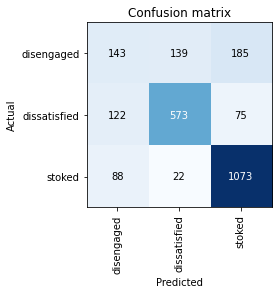

In [14]:
#collapse
interp.plot_confusion_matrix()